In [1]:
import numpy as np
import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints

from keras.engine.base_layer import Layer
# from keras.engine.base_layer import disable_tracking
from keras.engine.base_layer import InputSpec
from keras.utils.generic_utils import has_arg
from keras.utils.generic_utils import to_list

# Legacy support.
from keras.legacy.layers import Recurrent
from keras.legacy import interfaces

from keras.layers.recurrent import RNN

from keras.layers import Dense, LSTM
from keras.models import Sequential, Input, Model
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
look_back = 20

# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(3000)*(20*np.pi/1000))[:,None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)

train_size = 1000
val_size = 800
test_size = 500

# 데이터 분리
train = signal_data[0:train_size + look_back]
val = signal_data[1100: 1100 + val_size + look_back]
test = signal_data[2100: 2100 + test_size + look_back]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [4]:
# units 추가해야 함
class ENUCell(Layer):
    def __init__(self, units,
                 reset_activation='sigmoid',
                 update_activation='sigmoid',
                 cell_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 memory_state_kernel_initializer='orthogonal',
                 output_kernel_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 memory_state_kernel_regularizer=None,
                 output_kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 memory_state_kernel_constraint=None,
                 output_kernel_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 memory_state_dropout=0.,
                 output_dropout=0.,
                 implementation=2,
                 memory_state_after=False,
                 output_after=False,
                 **kwargs):
        super(ENUCell, self).__init__(**kwargs)
        self.output_size = units # memory size
        self.state_size =  units# output size <- 문제
        self.units = 4
        self.use_bias = use_bias
        
        self.reset_gate_activation = activations.get(reset_activation)
        self.update_gate_activation = activations.get(update_activation)
        self.cell_gate_activation = activations.get(cell_activation)

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.memory_state_kernel_initializer = initializers.get(memory_state_kernel_initializer)
        self.output_kernel_initializer = initializers.get(output_kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.memory_state_kernel_regularizer = regularizers.get(memory_state_kernel_regularizer)
        self.output_kernel_regularizer = regularizers.get(output_kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.memory_state_kernel_constraint = constraints.get(memory_state_kernel_constraint)
        self.output_kernel_constraint = constraints.get(output_kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.memory_state_dropout = min(1., max(0., memory_state_dropout))
        self.output_dropout = min(1., max(0., memory_state_dropout))
        
        self.implementation = implementation
        self.memory_state_after = memory_state_after
        self.output_after = output_after

        self._dropout_mask = None
        self._memory_state_dropout_mask = None
        self._output_dropout_mask = None
        
        self.h = None

    #-----------------------------------------------------------------------
    def build(self, input_shape):
        """
        z r h만 필요
        """
        input_dim = input_shape[-1]

#         if isinstance(self.recurrent_initializer, initializers.Identity):
#             def recurrent_identity(shape, gain=1., dtype=None):
#                 del dtype
#                 return gain * np.concatenate(
#                     [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

#             self.recurrent_initializer = recurrent_identity
        

        self.kernel = self.add_weight(shape=(input_dim,  self.units * 3),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        
        self.memory_state_kernel = self.add_weight(
            shape=(self.units, self.units * 3 + self.output_size),
            name='memory_state_kernel',
            initializer=self.memory_state_kernel_initializer,
            regularizer=self.memory_state_kernel_regularizer,
            constraint=self.memory_state_kernel_constraint)

        self.output_kernel = self.add_weight(
            shape=(self.output_size, self.units * 3),
            name='output_kernel',
            initializer=self.output_kernel_initializer,
            regularizer=self.output_kernel_regularizer,
            constraint=self.output_kernel_constraint)
        
        if self.use_bias: # 이해 필요
            if not self.memory_state_after and not self.output_after:
                bias_shape = (self.units * 3,)
            elif not self.memory_state_after or not self.output_after:
                bias_shape = (2, self.units * 3)
            else:
                bias_shape = (3, self.units * 3)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            # NOTE: need to flatten, since slicing in CNTK gives 2D array
            if not self.memory_state_after and not self.output_after:
                self.input_bias, self.memory_state_bias, self.output_bias = self.bias, None, None
            elif not self.memory_state_after:
                self.input_bias =  K.flatten(self.bias[0])
                self.memory_state_bias =  K.flatten(self.bias[1])
                self.output_bias = None
            elif not self.output_after:
                self.input_bias =  K.flatten(self.bias[0])
                self.memory_state_bias = None
                self.output_bias = K.flatten(self.bias[1])
            else:
                self.input_bias = K.flatten(self.bias[0])
                self.memory_state_bias = K.flatten(self.bias[1])
                self.output_bias = K.flatten(self.bias[2])

        else:
            self.bias = None

        # update gate
        self.kernel_z = self.kernel[:, :self.units]
        self.memory_state_kernel_z = self.memory_state_kernel[:, :self.units]
        self.output_kernel_z = self.output_kernel[:, :self.units]

        # reset gate
        self.kernel_r = self.kernel[:, self.units: self.units * 2]
        self.memory_state_kernel_r = self.memory_state_kernel[:,
                                                        self.units:
                                                        self.units * 2]
        self.output_kernel_r = self.output_kernel[:, self.units:self.units * 2]

        # new gate convert to cell gate
        self.kernel_h = self.kernel[:, self.units * 2:]
        self.memory_state_kernel_h = self.memory_state_kernel[:, self.units * 2:
                                                              self.units * 3]
        self.output_kernel_h = self.output_kernel[:, self.units * 2:]
        
        self.memory_state_kernel_o = self.memory_state_kernel[:, self.units * 3:]

        
        if self.use_bias:
            # bias for inputs
            self.input_bias_z = self.input_bias[:self.units]
            self.input_bias_r = self.input_bias[self.units: self.units * 2]
            self.input_bias_h = self.input_bias[self.units * 2:]
            # bias for hidden state - just for compatibility with CuDNN
            if self.memory_state_after:
                self.memory_state_bias_z = self.memory_state_bias[:self.units]
                self.memory_state_bias_r = (
                    self.memory_state_bias[self.units: self.units * 2])
                self.memory_state_bias_h = self.memory_state_bias[self.units * 2:]
            if self.output_after:
                self.output_bias_z = self.output_bias[:self.units]
                self.output_bias_r = (
                    self.output_bias[self.units: self.units * 2])
                self.output_bias_h = self.output_bias[self.units * 2:]
            
        else:
            self.input_bias_z = None
            self.input_bias_r = None
            self.input_bias_h = None
            if self.memory_state_after:
                self.memory_state_bias_z = None
                self.memory_state_bias_r = None
                self.memory_state_bias_h = None
            if self.output_after:
                self.output_bias_z = None
                self.output_bias_r = None
                self.output_bias_h = None
        self.built = True
        
        
    #-----------------------------------------------------------------------
    def call(self, inputs, states, training=None):
        o_tm1 = states[0]  # previous memory -> previous memory_state and output

        if self.h is None:
            self.h = K.zeros( (1, self.units), dtype='float32')
        h_tm1 = self.h

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=3)
        if (0 < self.memory_state_dropout < 1 and
                self._memory_state_dropout_mask is None):
            self._memory_state_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=3)
        if (0 < self.output_dropout < 1 and
                self._output_dropout_mask is None):
            self._output_dropout_mask = _generate_dropout_mask(
                K.ones_like(o_tm1),
                self.recurrent_dropout,
                training=training,
                count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        ms_dp_mask = self._memory_state_dropout_mask
        out_dp_mask = self._output_dropout_mask
        if self.implementation == 1:
            # dropout
            if 0. < self.dropout < 1.:
                inputs_z = inputs * dp_mask[0]
                inputs_r = inputs * dp_mask[1]
                inputs_h = inputs * dp_mask[2]
            else:
                inputs_z = inputs
                inputs_r = inputs
                inputs_h = inputs
            
            if 0. < self.memory_state_dropout < 1.:
                h_tm1_z = h_tm1 * rec_dp_mask[0]
                h_tm1_r = h_tm1 * rec_dp_mask[1]
                h_tm1_h = h_tm1 * rec_dp_mask[2]
            else:
                h_tm1_z = h_tm1
                h_tm1_r = h_tm1
                h_tm1_h = h_tm1
            
            if 0. < self.output_dropout < 1.:
                o_tm1_z = o_tm1 * rec_dp_mask[0]
                o_tm1_r = o_tm1 * rec_dp_mask[1]
                o_tm1_h = o_tm1 * rec_dp_mask[2]

            else:
                o_tm1_z = o_tm1
                o_tm1_r = o_tm1
                o_tm1_h = o_tm1

            # calculate gate
            x_z = K.dot(inputs_z, self.kernel_z) # update gate - update
            x_r = K.dot(inputs_r, self.kernel_r) # reset gate  - reset
            x_h = K.dot(inputs_h, self.kernel_h) # cell gate   - memory state

            if self.use_bias:
                x_z = K.bias_add(x_z, self.input_bias_z)
                x_r = K.bias_add(x_r, self.input_bias_r)
                x_h = K.bias_add(x_h, self.input_bias_h)

            ms_z = K.dot(h_tm1_z, self.memory_state_kernel_z)
            ms_r = K.dot(h_tm1_r, self.memory_state_kernel_r)
            if self.memory_state_after and self.use_bias:
                ms_z = K.bias_add(ms_z, self.memory_state_bias_z)
                ms_r = K.bias_add(ms_r, self.memory_state_bias_r)

            ##==============================================
            # output 계산
            out_z = K.dot(o_tm1_z, self.output_kernel_z)
            out_r = K.dot(o_tm1_r, self.output_kernel_r)
            out_h = K.dot(o_tm1_h, self.output_kernel_h)
            if self.output_after and self.use_bias:
                out_z = K.bias_add(out_z, self.output_bias_z)
                out_r = K.bias_add(out_r, self.output_bias_r)
                out_h = K.bias_add(out_h, self.output_bias_h)

            z = self.reset_gate_activation(x_z + ms_z + out_z)
            r = self.update_gate_activation(x_r + ms_r + out_r)
            
            # reset gate applied after/before matrix multiplication
            if self.memory_state_after:
                ms_h = K.dot(h_tm1_h, self.memory_state_kernel_h)
                if self.use_bias:
                    ms_h = K.bias_add(ms_h, self.memory_state_bias_h)
                ms_h = r * ms_h
            else:
                ms_h = K.dot(r * h_tm1_h, self.memory_state_kernel_h)
            
            hh = self.cell_gate_activation(x_h + ms_h + out_h)
        else: # 먼저 실행
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            if 0. < self.memory_state_dropout < 1.:
                h_tm1 *= ms_dp_mask[0]

            if 0. < self.output_dropout < 1.:
                o_tm1 *= out_dp_mask[0]
                
            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)

            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_z = matrix_x[:, :self.units]
            x_r = matrix_x[:, self.units: 2 * self.units]
            x_h = matrix_x[:, 2 * self.units:]


            if self.memory_state_after:
                # hidden state projected by all gate matrices at once
                matrix_inner = K.dot(h_tm1, self.memory_state_kernel[:, :2 * self.units])
                if self.use_bias:
                    matrix_inner = K.bias_add(matrix_inner, self.memory_state_bias[:, :2 * self.units])
            else:
                # hidden state projected separately for update/reset and new
                matrix_inner = K.dot(h_tm1,
                                     self.memory_state_kernel[:, :2 * self.units])

            ms_z = matrix_inner[:, :self.units]
            ms_r = matrix_inner[:, self.units: 2 * self.units]

            matrix_out = K.dot(o_tm1, self.output_kernel)
            if self.use_bias and self.output_after:
                # hidden state projected by all gate matrices at once
                matrix_out = K.bias_add(matrix_out, self.output_bias)
                # hidden state projected separately for update/reset and new
            
            out_z = matrix_out[:, :self.units]
            out_r = matrix_out[:, self.units: 2 * self.units]
            out_h = matrix_out[:, 2 * self.units:]
            
            z = self.reset_gate_activation(x_z + ms_z + out_z)
            
            r = self.update_gate_activation(x_r + ms_r + out_r)

            ms_h = K.dot(r * h_tm1, self.memory_state_kernel_h)
            if self.memory_state_after:
                ms_h = K.bias_add(ms_h, self.memory_state_bias_h)
            
            hh = self.cell_gate_activation(x_h + ms_h + out_h)
        
        # previous and candidate state mixed by update gate
        self.h = (1 - z) * h_tm1 + z * hh # new ms
        
        o = K.clip(K.dot(self.h, self.memory_state_kernel_o), 0, 1)
        
        if 0 < self.dropout + self.memory_state_dropout:
            if training is None:
                h._uses_learning_phase = True
        
        return o, [o]

    def get_config(self):
        config = {'units':self.units,
#                   'state_size': self.state_size,
#                   'output_size':self.output_size,
                  'reset_activation': activations.serialize(self.reset_gate_activation),
                  'update_activation':
                      activations.serialize(self.update_gate_activation),
                  'cell_activation':
                      activations.serialize(self.cell_gate_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'memory_state_kernel_initializer':
                      initializers.serialize(self.memory_state_kernel_initializer),
                  'output_kernel_initializer':
                      initializers.serialize(self.output_kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'memory_state_kernel_regularizer':
                      regularizers.serialize(self.memory_state_kernel_regularizer),
                  'output_kernel_regularizer':
                      regularizers.serialize(self.output_kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'memory_state_kernel_constraint':
                      constraints.serialize(self.memory_state_kernel_constraint),
                  'output_kernel_constraint':
                      constraints.serialize(self.output_kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'memory_state_dropout':self.memory_state_dropout,
                  'output_dropout': self.output_dropout,
                  'implementation': self.implementation,
                  'memory_state_after': self.memory_state_after,
                  'output_after': self.output_after}
        base_config = super(ENUCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
class ENU(RNN):
    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 reset_activation='sigmoid',
                 update_activation='sigmoid',
                 cell_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 memory_state_kernel_initializer='orthogonal',
                 output_kernel_initializer='orthogonal',
                 bias_initializer='zeros',
                 activity_regularizer=None,
                 kernel_regularizer=None,
                 memory_state_kernel_regularizer=None,
                 output_kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 memory_state_kernel_constraint=None,
                 output_kernel_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 memory_state_dropout=0.,
                 output_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 memory_state_after=False,
                 output_after=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or memory_state_dropout or output_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            memory_state_dropout = 0.
            output_dropout = 0.

        cell = ENUCell(units,
                     reset_activation=reset_activation,
                     update_activation=update_activation,
                     cell_activation=cell_activation,
                     use_bias=use_bias,
                     kernel_initializer=kernel_initializer,
                     memory_state_kernel_initializer=memory_state_kernel_initializer,
                     output_kernel_initializer=output_kernel_initializer,
                     bias_initializer=bias_initializer,
                     kernel_regularizer=kernel_regularizer,
                     memory_state_kernel_regularizer=memory_state_kernel_regularizer,
                     output_kernel_regularizer=output_kernel_regularizer,
                     bias_regularizer=bias_regularizer,
                     kernel_constraint=kernel_constraint,
                     memory_state_kernel_constraint=memory_state_kernel_constraint,
                     output_kernel_constraint=output_kernel_constraint,
                     bias_constraint=bias_constraint,
                     dropout=dropout,
                     memory_state_dropout=memory_state_dropout,
                     output_dropout=output_dropout,
                     implementation=implementation,)
        super(ENU, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._memory_state_dropout_mask = None
        self.cell._output_dropout_mask = None
        
        return super(ENU, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    def state_size(self):
        return self.cell.state_size

    @property
    def reset_activation(self):
        return self.cell.reset_activation
    
    @property
    def update_activation(self):
        return self.cell.update_activation
    
    @property
    def cell_activation(self):
        return self.cell.cell_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def memory_state_kernel_initializer(self):
        return self.cell.memory_state_kernel_initializer

    @property
    def output_kernel_initializer(self):
        return self.cell.output_kernel_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def memory_state_kernel_regularizer(self):
        return self.cell.memory_state_kernel_regularizer
    
    @property
    def output_kernel_regularizer(self):
        return self.cell.output_kernel_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def memory_state_kernel_constraint(self):
        return self.cell.memory_state_kernel_constraint
    
    @property
    def output_kernel_constraint(self):
        return self.cell.output_kernel_constraint
    
    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def output_dropout(self):
        return self.cell.output_dropout
    
    @property
    def implementation(self):
        return self.cell.implementation

    @property
    def memory_state_after(self):
        return self.cell.memory_state_after

    @property
    def output_after(self):
        return self.cell.output_after

    def get_config(self):
        config = {'units': self.units,
#                   'output_size': self.cell.output_size,
#                   'state_size': self.cell.state_size,
                  'reset_activation': activations.serialize(self.cell.reset_gate_activation),
                  'update_activation':
                      activations.serialize(self.cell.update_gate_activation),
                  'cell_activation':
                      activations.serialize(self.cell.cell_gate_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.cell.kernel_initializer),
                  'memory_state_kernel_initializer':
                      initializers.serialize(self.cell.memory_state_kernel_initializer),
                  'output_kernel_initializer':
                      initializers.serialize(self.cell.output_kernel_initializer),
                  'bias_initializer': initializers.serialize(self.cell.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.cell.kernel_regularizer),
                  'memory_state_kernel_regularizer':
                      regularizers.serialize(self.cell.memory_state_kernel_regularizer),
                  'output_kernel_regularizer':
                      regularizers.serialize(self.cell.output_kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.cell.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.cell.kernel_constraint),
                  'memory_state_kernel_constraint':
                      constraints.serialize(self.cell.memory_state_kernel_constraint),
                  'output_kernel_constraint':
                      constraints.serialize(self.cell.output_kernel_constraint),
                  'bias_constraint': constraints.serialize(self.cell.bias_constraint),
                  'dropout': self.dropout,
                  'memory_state_dropout':self.cell.memory_state_dropout,
                  'output_dropout': self.cell.output_dropout,
                  'implementation': self.cell.implementation,
                  'memory_state_after': self.cell.memory_state_after,
                  'output_after': self.cell.output_after}
        base_config = super(ENU, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [13]:
model = Sequential()
model.add(ENU(3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='sgd', learning_rate=1)

3 3 4


In [14]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_val, y_val), verbose=2)

-=-=-=-=-=-=-=-=--==-=--==--=-=-=-=-=-=-=--==--=-=-=-=-=-=-=-=-==-=---==-=
3 3 4
o_tm1 Tensor("enu_2/Tile:0", shape=(?, 3), dtype=float32)
Tensor("enu_2/clip_by_value:0", shape=(?, 3), dtype=float32)
o_tm1 Tensor("enu_2/while/Identity_3:0", shape=(?, 3), dtype=float32)
Tensor("enu_2/while/clip_by_value:0", shape=(?, 3), dtype=float32)
Train on 1000 samples, validate on 800 samples
Epoch 1/100
 - 1s - loss: 0.3023 - val_loss: 0.2634
Epoch 2/100
 - 0s - loss: 0.2405 - val_loss: 0.2129
Epoch 3/100
 - 0s - loss: 0.1968 - val_loss: 0.1777
Epoch 4/100
 - 0s - loss: 0.1664 - val_loss: 0.1528
Epoch 5/100
 - 0s - loss: 0.1448 - val_loss: 0.1353
Epoch 6/100
 - 0s - loss: 0.1296 - val_loss: 0.1228
Epoch 7/100
 - 0s - loss: 0.1188 - val_loss: 0.1139
Epoch 8/100
 - 0s - loss: 0.1111 - val_loss: 0.1076
Epoch 9/100
 - 0s - loss: 0.1055 - val_loss: 0.1029
Epoch 10/100
 - 0s - loss: 0.1014 - val_loss: 0.0995
Epoch 11/100
 - 0s - loss: 0.0984 - val_loss: 0.0969
Epoch 12/100
 - 0s - loss: 0.0960 - val_lo

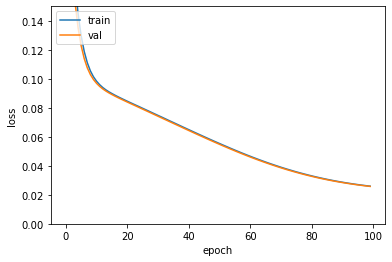

In [15]:
# 5. 학습과정 살펴보기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_val, y_val, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.025796512074768543
Validataion Score:  0.025796511918306352
Test Score:  0.02579651189222932


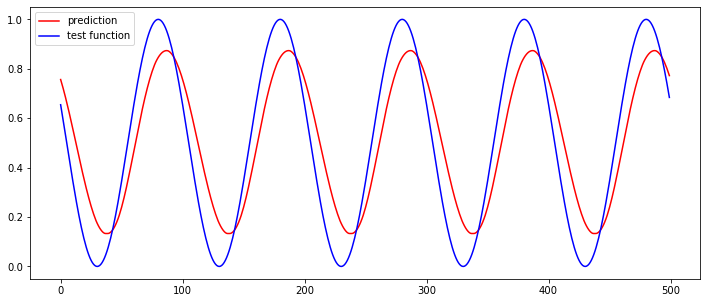

In [17]:
prediction = model.predict(x_test)

plt.figure(figsize=(12,5))
plt.plot(np.arange(y_test.shape[0]), prediction, 'r', label="prediction")
plt.plot(np.arange(y_test.shape[0]), y_test, 'b', label="test function")
plt.legend()
plt.show()